スパースモデリング第11章
==
# MAP推定とMMSE推定

In [1]:
from matplotlib.font_manager import FontProperties

font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

数値例
--

In [2]:
class NumericalExample(object):
    """ 数値例 """

    def __init__(self, n=20, m=30, k=3, sig_x=1., sig_e=0.1):
        
        # パラメータ 
        self.n = n
        self.m = m
        self.k = k
        self.sig_x = sig_x
        self.sig_e = sig_e
        
        # 辞書A
        self.A = np.random.randn(n, m)
        self.A = np.dot(self.A, np.diag(1. / np.sqrt(np.diag(np.dot(self.A.T, self.A)))))

        # スパースベクトルx
        self.x = np.zeros(m)
        self.ndx = np.random.permutation(range(m))[:k]
        self.x[self.ndx] = np.random.randn(k) * sig_x
    
        # 信号z
        self.z = np.dot(self.A, self.x)

        # ノイズベクトルe
        self.e = np.random.randn(n) * sig_e
    
        # 観測されるベクトルy
        self.y = self.z + self.e 

MAP推定とMMSE推定
--

(0, 29)

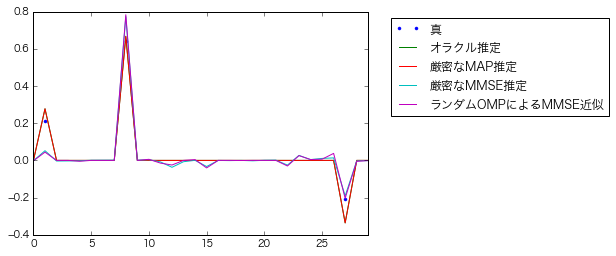

In [74]:
from itertools import combinations

class MAP_MMSE(object):
    """ MAP推定 """
    def __init__(self, nr):
        # 数値例を引き継ぎ
        self.nr = nr
    
    def get_Q(self, A):
        """ Q^-1を得る """
#         return np.linalg.inv(np.dot(A.T, A)/ (self.nr.sig_e ** 2) + 1. / (self.nr.sig_x ** 2))
        return np.linalg.pinv(np.dot(A.T, A)/ (self.nr.sig_e ** 2) + 1. / (self.nr.sig_x ** 2))

    def oracle(self, s):
        """ オラクル推定 """
        A_s = self.nr.A[:, s]
        a = self.get_Q(A_s)
        b = np.dot(A_s.T, self.nr.y) / (self.nr.sig_e ** 2)
        x_hat = np.zeros_like(self.nr.x)
        x_hat[s] = np.dot(a, b)
        return x_hat, s
     
    def exhaustive_search_MAP_support(self):
        """ MAPサポートを全探索 """
        p_max = 0
        for s in combinations(range(self.nr.m), self.nr.k):
            A_s = self.nr.A[:, s]
            a = self.get_Q(A_s)
            b = np.dot(A_s.T, self.nr.y)
            p = np.dot(b.T, np.dot(a, b))
            if p > p_max:
                p_max = p
                s_max = s
        return np.array(s_max)

    def exact_MAP(self):
        """ 厳密なMAP推定を得る """
        return self.oracle(self.exhaustive_search_MAP_support())

    def exact_MMSE(self):
        """ 厳密なMMSE推定を得る """
        nor = 0.
        x_hat = np.zeros_like(self.nr.x)
        for s in combinations(range(self.nr.m), self.nr.k):
            s = np.array(s)
            A_s = self.nr.A[:, s]
            a = self.get_Q(A_s)
            b = np.dot(A_s.T, self.nr.y) / (self.nr.sig_e ** 2)
            x_s = np.dot(a, b)
#             q_s = np.exp(np.dot(b.T, x_s) / 2 + np.log(np.linalg.det(a)) / 2)
            q_s = np.exp(np.dot(b.T, x_s) / 2)
            x_hat[s] += x_s * q_s
            nor += q_s
        return x_hat / nor
    
    def random_OMP(self, J=25):
        """ 近似MMSE推定を得るためのランダムOMP """
        # 定数
        sig_e2 = self.nr.sig_e ** 2
        sig_x2 = self.nr.sig_x ** 2
        C = 1 / (2 * sig_e2 * (1 + sig_e2 / sig_x2))
        C2 = np.log(1 / sig_e2 + 1 / sig_x2) / 2
        
        x_hat = np.zeros_like(self.nr.x)
        for _ in range(J):
            # 初期化
            x = np.zeros(self.nr.A.shape[1])
            S = np.zeros(self.nr.A.shape[1], dtype=np.uint8)
            r = self.nr.y.copy()

            for _ in range(self.nr.k):
                # サポート更新
                q = np.exp((np.dot(self.nr.A.T, r) ** 2) * C + C2)
                q /= q.sum()
                q_sum = np.cumsum(q)
                
                while True:
                    p = np.random.rand()
                    ndx = np.where(q_sum > p)[0]
                    if S[ndx[0]] == 0:
                        S[ndx[0]] = 1
                        break

                # 解更新
                As = self.nr.A[:, S == 1]
                pinv = np.linalg.pinv(np.dot(As, As.T))
                x[S == 1] = np.dot(As.T, np.dot(pinv, self.nr.y))
        
                # 残差更新
                r = self.nr.y - np.dot(self.nr.A, x)
            
            ndx = np.where(S == 1)[0]
            x, S = self.oracle(ndx)
            x_hat += x

        return x_hat / J        
    
nr = NumericalExample()
map_mmse = MAP_MMSE(nr)
x_oracle, s_oracle = map_mmse.oracle(nr.ndx)
x_exact_MAP, s_exact_MAP = map_mmse.exact_MAP()
x_exact_MMSE = map_mmse.exact_MMSE()
x_random_OMP = map_mmse.random_OMP()

plt.plot(nr.ndx, nr.x[nr.ndx], '.', label='真')
plt.plot(x_oracle, label='オラクル推定')
plt.plot(x_exact_MAP, label='厳密なMAP推定')
plt.plot(x_exact_MMSE, label='厳密なMMSE推定')
plt.plot(x_random_OMP, label='ランダムOMPによるMMSE近似')

plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.xlim(0, 29)

貪欲法
--

In [24]:
class Greedy(object):
    """ 貪欲法 """
    def __init__(self, A, b, eps=1e-4):
        """
        A m×n行列
        b n要素の観測
        eps 誤差の閾値
        """
        self.A = A
        self.b = b
        self.eps = eps

    def OMP(self):
        """ 直交マッチング追跡(orthogonal matching pursuit; OMP) """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in range(self.A.shape[1]):
            # 誤差計算
            err = rr - np.dot(self.A[:, S == 0].T, r) ** 2
            
            # サポート更新
            ndx = np.where(S == 0)[0]
            S[ndx[err.argmin()]] = 1
    
            # 解更新
            As = self.A[:, S == 1]
            pinv = np.linalg.pinv(np.dot(As, As.T))
            x[S == 1] = np.dot(As.T, np.dot(pinv, self.b))
        
            # 残差更新
            r = self.b - np.dot(self.A, x)
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S
    
    def MP(self):
        """ マッチング追跡(matching pursuit; MP) """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in range(1000):
            # 誤差計算
            err = rr - np.dot(self.A.T, r) ** 2

            # サポート更新
            j = err.argmin()
            S[j] = 1
    
            # 解更新
            a = self.A[:, j]
            z = np.dot(a, r)
            x[j] += z
    
            # 残差更新
            r -= z * a
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S

    def WMP(self, t=0.5):
        """ 
        弱マッチング追跡(weak matching pursuit; WMP)     
        t スカラー(0<t<1)
        """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in range(1000):
            # 誤差計算
            max_zz = 0
            j0 = 0
            for j in range(self.A.shape[1]):
                a = self.A[:, j]
                z = np.dot(a, r)
                if np.abs(z) > t * np.sqrt(rr):
                    j0 = j
                    break
                if z ** 2 > max_zz:
                    max_zz = z ** 2
                    j0 = j 
    
            # サポート更新
            S[j0] = 1
    
            # 解更新
            a = self.A[:, j0]
            z = np.dot(a, r)
            x[j0] += z
    
            # 残差更新
            r -= z * a
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S

    def Threshold(self, k):
        """ 
        閾値アルゴリズム(thresholding algorithm) 
        k 列の個数
        """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)

        # 誤差計算
        err = rr - np.dot(self.A.T, r) ** 2

        # サポートの更新
        ndx = np.argsort(err)[:k]
        S[ndx] = 1
        
        # 解更新
        As = self.A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S == 1] = np.dot(As.T, np.dot(pinv, self.b))
        
        return x, S

[4, 9, 28]
[4, 9, 28]
[9, 28]


(0, 29)

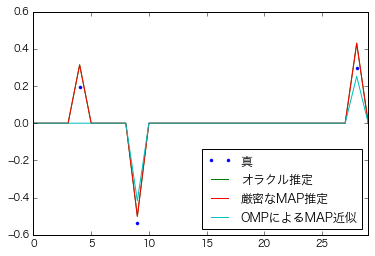

In [40]:
nr = NumericalExample()
map_mmse = MAP_MMSE(nr)
x_oracle, s_oracle = map_mmse.oracle(nr.ndx)
x_exact_MAP, s_exact_MAP = map_mmse.exact_MAP()

eps = nr.n * (nr.sig_e ** 2)
greedy = Greedy(nr.A, nr.y, eps=eps)
x_OMP, s_OMP = greedy.OMP()

print(sorted(s_oracle))
print(sorted(s_exact_MAP))
print(sorted(np.arange(nr.m)[s_OMP == 1]))

plt.plot(nr.ndx, nr.x[nr.ndx], '.', label='真')
plt.plot(x_oracle, label='オラクル推定')
plt.plot(x_exact_MAP, label='厳密なMAP推定')
plt.plot(x_OMP, label='OMPによるMAP近似')

plt.legend(loc='best')
plt.xlim(0, 29)

In [121]:
def get_se(x, x2):
    """ 二乗誤差を得る """
    return np.sum((x - x2) ** 2)

n_iter = 100
log = []
for sig_e in np.arange(0.1, 2.1, 0.1):
    se = np.zeros(3)
    eps = nr.n * (nr.sig_e ** 2)
    for _ in range(n_iter):
        nr = NumericalExample(sig_e=sig_e)

        map_estimation = MAP_Estimation(nr)
        x_oracle, s_oracle = map_estimation.oracle(nr.ndx)
        se[0] += get_se(nr.x, x_oracle)

        x_exact_MAP, s_exact_MAP = map_estimation.exact_MAP()
        se[1] += get_se(nr.x, x_exact_MAP)

        greedy = Greedy(nr.A, nr.y, eps=eps)
        x_OMP, s_OMP = greedy.OMP()
        se[2] += get_se(nr.x, x_OMP)

    se /= n_iter * (eps)
    print(sig_e, se)
    log.append(se)

0.1 [ 0.0003693   0.00104158  0.01519097]
0.2 [ 0.72673877  3.58887954  8.09969686]
0.3 [ 0.3907274   2.19521756  2.75641283]
0.4 [ 0.31949776  1.77971149  1.80712755]
0.5 [ 0.30629877  1.37285149  1.64501181]
0.6 [ 0.25786267  1.28713238  1.27424043]
0.7 [ 0.20542938  1.14535842  0.99863574]
0.8 [ 0.2044694   1.06494388  0.80417172]
0.9 [ 0.17008704  0.94307415  0.71707887]
1.0 [ 0.16762222  0.95653018  0.69401969]
1.1 [ 0.18771147  0.93921935  0.61607653]
1.2 [ 0.17552964  0.84610487  0.56559557]
1.3 [ 0.14871965  0.84781611  0.54181826]
1.4 [ 0.15369738  0.76604843  0.51856018]
1.5 [ 0.14802898  0.809343    0.57636727]
1.6 [ 0.16165555  0.82733587  0.5603528 ]
1.7 [ 0.13394511  0.78367018  0.59061939]
1.8 [ 0.11861403  0.73685626  0.48323865]
1.9 [ 0.14414339  0.70014671  0.46181071]
2.0 [ 0.12604783  0.71743075  0.44153403]


(0, 19)

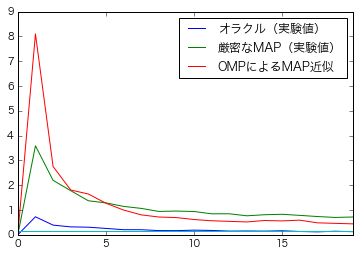

In [129]:
ses = np.array(log)
plt.plot(ses[:, 0], label='オラクル（実験値）')
plt.plot(ses[:, 1], label='厳密なMAP（実験値）')
plt.plot(ses[:, 2], label='OMPによるMAP近似')
plt.plot(['0.15'] * 20)
plt.legend(loc='best')
plt.xlim(0, 19)

In [76]:
def get_se(x, x2):
    """ 二乗誤差を得る """
    return np.sum((x - x2) ** 2)

n_iter = 100
log = []
for sig_e in np.arange(0.1, 2.1, 0.1):
    se = np.zeros(4)
    eps = nr.n * (nr.sig_e ** 2)
    for _ in range(n_iter):
        nr = NumericalExample(sig_e=sig_e)
        map_mmse = MAP_MMSE(nr)

        x_oracle, s_oracle = map_mmse.oracle(nr.ndx)
        x_exact_MAP, s_exact_MAP = map_mmse.exact_MAP()
        x_exact_MMSE = map_mmse.exact_MMSE()
        x_random_OMP = map_mmse.random_OMP()

        for i, x_hat in enumerate([x_oracle, x_exact_MAP, x_exact_MMSE, x_random_OMP]):
            se[i] += get_se(nr.x, x_hat)

    se /= n_iter * (eps)
    print(sig_e, se)
    log.append(se)

0.1 [ 0.00044     0.0013976   0.00095996  0.00125567]
0.2 [ 0.73208564  3.70906053  2.01823807  2.2367279 ]
0.3 [ 0.36605576  2.15514098  1.04021538  1.14675945]
0.4 [ 0.32440074  1.76830061  0.77724742  0.74764433]
0.5 [ 0.21350643  1.37245394  0.57246151  0.54611098]
0.6 [ 0.22689841  1.19738051  0.45475264  0.40564306]
0.7 [ 0.20395832  1.07014817  0.34678792  0.30261428]
0.8 [ 0.19703941  1.02936889  0.31265596  0.25761123]
0.9 [ 0.17444832  0.9936632   0.30602509  0.23982222]
1.0 [ 0.1539231   0.99251643  0.21600196  0.16487232]
1.1 [ 0.16797549  0.85778807  0.2167658   0.15637164]
1.2 [ 0.17457935  0.84879426  0.17738962  0.12802184]
1.3 [ 0.16346656  0.80594008  0.14892858  0.10945177]
1.4 [ 0.1463221   0.8754714   0.16777723  0.09926609]
1.5 [ 0.16323353  0.86579225  0.14481295  0.09039331]
1.6 [ 0.14485239  0.79638665  0.1405835   0.07715135]
1.7 [ 0.13279856  0.80541283  0.15144552  0.06753133]
1.8 [ 0.13917656  0.76045129  0.13630606  0.06187052]
1.9 [ 0.13082284  0.7234378 

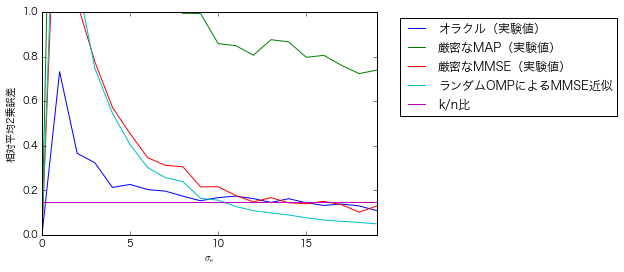

In [83]:
log = np.array(log)
plt.plot(log[:, 0], label='オラクル（実験値）')
plt.plot(log[:, 1], label='厳密なMAP（実験値）')
plt.plot(log[:, 2], label='厳密なMMSE（実験値）')
plt.plot(log[:, 3], label='ランダムOMPによるMMSE近似')
plt.plot(['0.15'] * 20, label='k/n比')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.xlim(0, 19)
plt.ylim(0, 1)
plt.xlabel('$\sigma_{e}$')
plt.ylabel('相対平均2乗誤差')